In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import GENConv, GATv2Conv, SSGConv
import numpy as np
from torch_geometric.data import Data
from torch.utils.data import DataLoader
import torch_geometric.utils

from tqdm import tqdm

from sklearn.model_selection import KFold
import pandas as pd
from MatrixVectorizer import MatrixVectorizer


In [2]:
# set global variables
N_SUBJECTS = 167

N_LR_NODES = 160

N_HR_NODES = 268

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

N_LR_NODES_F = int(N_LR_NODES * (N_LR_NODES-1) / 2)
N_HR_NODES_F = int(N_HR_NODES * (N_HR_NODES-1) / 2)

In [3]:
from data_preparation import load_data_tensor

lr_train, lr_test, hr_train = load_data_tensor("data")

lr_X_dim1 = torch.load('model_autoencoder/final_embeddings/encode_lr.pt')
lr_X_dim3 = torch.load('model_autoencoder/final_embeddings/encode_lr_3.pt')
hr_X_dim1 = torch.load('model_autoencoder/final_embeddings/encode_hr.pt')
hr_X_dim3 = torch.load('model_autoencoder/final_embeddings/encode_hr_3.pt')
lr_X_dim1_test = torch.load('model_autoencoder/final_embeddings/encode_lr_test.pt')
hr_X_dim3_test = torch.load('model_autoencoder/final_embeddings/encode_lr_test_3.pt')

In [27]:
import numpy as np

adj_matrices_list = [tensor.numpy() for tensor in lr_train]

In [31]:
from karateclub import Graph2Vec
from sklearn.cluster import SpectralClustering
import networkx as nx
import numpy as np

# Example: Creating a list of graphs for demonstration
# Replace this with loading/creating your own graphs

graphs = [nx.from_numpy_matrix(adj_matrix, create_using=nx.DiGraph) for adj_matrix in adj_matrices_list]

# Step 1: Generate embeddings for each graph using Graph2Vec
graph2vec = Graph2Vec(dimensions=50)
graph2vec.fit(graphs)
graph_embeddings = graph2vec.get_embedding()

# Step 2: Apply Spectral Clustering on the embeddings
num_clusters = 3   # Set the number of clusters you want to divide the graphs into
clustering_model = SpectralClustering(n_clusters=num_clusters, assign_labels="discretize", random_state=0)
clusters = clustering_model.fit_predict(graph_embeddings)

# 'clusters' now contains the cluster assignments for each graph
print("Cluster assignments:", clusters)
print()
from sklearn.metrics import silhouette_score

# Calculate the silhouette score
score = silhouette_score(graph_embeddings, clusters)
print("Silhouette Score: ", score)


Cluster assignments: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Silhouette Score:  0.9256053


In [32]:
adj_matrices_list = [tensor.numpy() for tensor in hr_train]

In [45]:
from karateclub import Graph2Vec
from sklearn.cluster import SpectralClustering
import networkx as nx
import numpy as np

# Example: Creating a list of graphs for demonstration
# Replace this with loading/creating your own graphs

graphs = [nx.from_numpy_matrix(adj_matrix, create_using=nx.DiGraph) for adj_matrix in adj_matrices_list]

# Step 1: Generate embeddings for each graph using Graph2Vec
graph2vec = Graph2Vec(dimensions=130)
graph2vec.fit(graphs)
graph_embeddings = graph2vec.get_embedding()

# Step 2: Apply Spectral Clustering on the embeddings
num_clusters = 2  # Set the number of clusters you want to divide the graphs into
clustering_model = SpectralClustering(n_clusters=num_clusters, assign_labels="discretize", random_state=0)
clusters = clustering_model.fit_predict(graph_embeddings)

# 'clusters' now contains the cluster assignments for each graph
print("Cluster assignments:", clusters)
print()
from sklearn.metrics import silhouette_score

# Calculate the silhouette score
score = silhouette_score(graph_embeddings, clusters)
print("Silhouette Score: ", score)


Cluster assignments: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]

Silhouette Score:  0.8196793


In [52]:
indices = np.where(clusters == 1)[0]
idxs = list(indices)

In [81]:
additional = lr_train[idxs, : , : ]
result_tensor = torch.repeat_interleave(additional, repeats=4, dim=0)
additional_hr = hr_train[idxs, :, : ]
result_tensor_hr = torch.repeat_interleave(additional_hr, repeats=4, dim=0)

In [82]:
lr_train = torch.cat((lr_train, result_tensor), dim=0)
hr_train = torch.cat((hr_train, result_tensor_hr), dim=0)

In [83]:
lr_train.size()
hr_train.size()

torch.Size([187, 268, 268])

# Model Layers

In [84]:
def generate_steps(num_steps, low=N_LR_NODES, high=N_HR_NODES):
    step_size = (high - low) / (num_steps - 1)
    steps_list = [round(low + step_size * i) for i in range(num_steps)]
    return steps_list

In [86]:
class StackedGCN(nn.Module):
    def __init__(self, n_nodes, channel_ls, dropout):
        super().__init__()
        self.n_nodes = n_nodes
        self.gcn_layers, self.batch_norm_layers = self._init_layers(channel_ls)

        # self.gcn_layers, _ = self._init_layers(channel_ls)
        self.dropout = dropout
        
    
    def forward(self, X, A):
        for i in range(len(self.gcn_layers)):
            gcn = self.gcn_layers[i]
            batch_norm = self.batch_norm_layers[i]
            graph_batch = self._create_batch(X, A)
            
            X = F.sigmoid(gcn(graph_batch.x, graph_batch.edge_index, graph_batch.edge_attr).reshape(*X.shape[:2], -1))
            torch.cuda.empty_cache()
            X = F.dropout(batch_norm(X), self.dropout, training=self.training)
            # X = F.dropout(X, self.dropout, training=self.training)
            torch.cuda.empty_cache()

        return X

    def _init_layers(self, channel_ls):
        layers_ls = []
        batch_norm_ls = []
        for i in range(len(channel_ls) - 1):
            layer = GATv2Conv(channel_ls[i], channel_ls[i], heads=2, edge_dim=1)
            layers_ls.append(layer)
            batch_norm_ls.append(torch_geometric.nn.norm.BatchNorm(self.n_nodes))
        return nn.ModuleList(layers_ls), nn.ModuleList(batch_norm_ls)

    def _create_batch(self, X, A):
        data_list = []
        for x, adj in zip(X, A):
            edge_index = adj.nonzero().t()
            edge_weights = adj[edge_index[0], edge_index[1]]
            edge_index, edge_weights = torch_geometric.utils.add_self_loops(edge_index, edge_weights) # add self connections
            data = Data(x=x, edge_index=edge_index, edge_attr=edge_weights.view(-1, 1))
            data_list.append(data)
        return torch_geometric.data.Batch().from_data_list(data_list)

In [87]:
class AdjacencyStep(nn.Module):
    def __init__(self, old_dim, new_dim, channels_ls, dt=1., alpha=0.9, gamma=0.9, dropout=0.25):
        super().__init__()
        self.dt = dt
        self.alpha = alpha
        self.gamma = gamma
        self.gnn = StackedGCN(old_dim, channels_ls, dropout).to(DEVICE)
        self.dropout = dropout
        # self.dim_changer1 = nn.Parameter(torch.randn((new_dim, 1), device=DEVICE))
        # self.dim_changer2 = nn.Parameter(torch.randn((1, old_dim), device=DEVICE))
        self.dim_changer = nn.Parameter(torch.randn((new_dim, old_dim), device=DEVICE))

        self.A_dim_changer = nn.Parameter(torch.randn((new_dim, old_dim), device=DEVICE))
        # self.A_dim_changer1 = nn.Parameter(torch.randn((new_dim, 1), device=DEVICE))   
        # self.A_dim_changer2 = nn.Parameter(torch.randn((1, old_dim), device=DEVICE))
        self.A_dim_bias = nn.Parameter(torch.zeros((new_dim, 1), device=DEVICE))

        self.Z_dim_changer = nn.Parameter(torch.randn((channels_ls[-1], new_dim), device=DEVICE))
        # self.Z_dim_changer1 = nn.Parameter(torch.randn((channels_ls[-1], 1), device=DEVICE))   
        # self.Z_dim_changer2 = nn.Parameter(torch.randn((1, new_dim), device=DEVICE))
        self.Z_dim_bias = nn.Parameter(torch.zeros((new_dim, 1), device=DEVICE))

        self.Z_dim_lower = nn.Conv1d(channels_ls[-1], channels_ls[0], kernel_size=1)


        self.forget_gate = nn.Parameter(torch.randn(new_dim, device=DEVICE))
        self.input_gate = nn.Parameter(torch.randn(new_dim, device=DEVICE))

        self.batchnorm_A = torch_geometric.nn.norm.BatchNorm(new_dim)
        self.layernorm_forget_A = torch_geometric.nn.norm.LayerNorm((new_dim, new_dim))
        self.layernorm_input_Z = torch_geometric.nn.norm.LayerNorm((new_dim, new_dim))
        self.batchnorm_X = torch_geometric.nn.norm.BatchNorm(new_dim)
        self.batchnorm_Y = torch_geometric.nn.norm.BatchNorm(new_dim)



    def forward(self, X, Y, A):
        # solve ODEs using simple IMEX scheme
        # dim_changer = self.dim_changer1 @ self.dim_changer2 
        # A_dim_changer = self.A_dim_changer1 @ self.A_dim_changer2
        # Z_dim_changer = self.Z_dim_changer1 @ self.Z_dim_changer2
        dim_changer = self.dim_changer
        A_dim_changer = self.A_dim_changer
        Z_dim_changer = self.Z_dim_changer

        # forget gate from previous adjacency
        f = F.sigmoid(self.forget_gate)
        i = F.sigmoid(self.input_gate)
        forget_A = F.elu(A_dim_changer @ A @ A_dim_changer.T + self.A_dim_bias)
        forget_A = f[:, None] * self.layernorm_forget_A(forget_A)
        # forget_A = f[:, None] * forget_A
        torch.cuda.empty_cache()

    
        # update node features with gcn
        Z = self.gnn(X, A)
        torch.cuda.empty_cache()
        input_Z = F.elu(dim_changer @ Z @ Z_dim_changer + self.Z_dim_bias)
        input_Z = i[:, None] * self.layernorm_input_Z(input_Z)
        # input_Z = i[:, None] * input_Z
        torch.cuda.empty_cache()



        # get new adjacency matrix
        new_A = forget_A + input_Z
        new_A = self.batchnorm_A(new_A)
        new_A = (new_A + torch.transpose(new_A, -1, -2)) / 2
        # new_A = F.tanh(F.relu(new_A))
        new_A = F.hardtanh(F.hardtanh(new_A, min_val=0), min_val=0)


        torch.cuda.empty_cache()


        # update feature embeiddings
        Z = torch.transpose(self.Z_dim_lower(torch.transpose(Z, -1, -2)), -1, -2)
        Y_temp = Y
        Y = dim_changer @ (Y + self.dt * (Z - self.alpha * Y - self.gamma * X))
        X = dim_changer @ (X + self.dt * Y_temp) 

        X = self.batchnorm_X(X)
        Y = self.batchnorm_Y(Y)   
        torch.cuda.empty_cache()


        Y = F.dropout(Y, self.dropout, training=self.training)
        X = F.dropout(X, self.dropout, training=self.training)

        return X, Y, new_A

    

In [88]:
class AdjacencyDimChanger(nn.Module):

    def __init__(self, dim_steps, channels_ls):
        super().__init__()
        
        self.layers = nn.ModuleList([AdjacencyStep(dim_steps[i], dim_steps[i+1], channels_ls) for i in range(len(dim_steps)-1)])
        # self.batchnorms = nn.ModuleList([nn.BatchNorm1d(dim_steps[i+1]) for i in range(len(dim_steps)-1)])
        
    def forward(self, X, Y, A):
        adj_ls = [A]
        x, y, adj = X, Y, A
        
        for layer in self.layers:
            x, y, adj = layer(x, y, adj)
            adj_ls.append(adj)
            
        return adj_ls
        

In [89]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True

In [91]:
import numpy as np
import networkx as nx

def eigen_centrality(data):
    # ROI is the number of brain regions (i.e.,35 in our case)
    ROI = 160

    topology_eigen = []

    G = nx.from_numpy_array(np.absolute(data))
    U = G.to_undirected()

    # A = to_2d(data)
    np.fill_diagonal(data, 0)

    # create a graph frL2
    # # compute egeinvector centrality and transform the output to vector
    ec = nx.eigenvector_centrality_numpy(U)
    
    eigenvector_centrality = np.array([ec[g] for g in U])



    topology_eigen.append(eigenvector_centrality)  # 2

    return topology_eigen

def pearson_coor(input, target, epsilon=1e-7):
    vx = input - torch.mean(input, dim=(1, 2))[:, None, None]
    vy = target - torch.mean(target, dim=(1, 2))[:, None, None]
    cost = torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2)+epsilon) * torch.sqrt(torch.sum(vy ** 2)+epsilon)+epsilon)
    return cost

def GT_loss(target, predicted):

    # l1_loss
    l1_loss = torch.nn.L1Loss()
    # loss_pix2pix = l1_loss(target, predicted)

    # topological_loss
    target_n = target.detach().cpu().clone().numpy()
    predicted_n = predicted.detach().cpu().clone().numpy()
    torch.cuda.empty_cache()

    topo_loss = []
    

    for i in range(len(target_n)):

        cur_target = target_n[i]
        cur_predicted = predicted_n[i]

        target_t = eigen_centrality(cur_target)
        real_topology = torch.tensor(target_t[0])
        predicted_t = eigen_centrality(cur_predicted)
        fake_topology = torch.tensor(predicted_t[0])
        topo_loss.append(l1_loss(real_topology, fake_topology))

    topo_loss = torch.sum(torch.stack(topo_loss))

    pc_loss = pearson_coor(target, predicted).to(DEVICE)
    torch.cuda.empty_cache()

    # G_loss = loss_pix2pix + (1 - pc_loss) + topo_loss
    G_loss = (1 - pc_loss) + topo_loss


    return G_loss

In [93]:
def loss_calc(adj_ls, opp_adj_ls, alpha=0.75, weights=None):
    total_loss = torch.Tensor([0]).to(DEVICE)
    mse_loss_fn = nn.MSELoss()

    # calculate the loss for the upper traingle of the matrix because thats what we care about
    final_dim = adj_ls[-1].shape[-1]
    upper_tri_idx = torch.triu_indices(final_dim, final_dim, offset=1)
    final_upper_tri_adj = adj_ls[-1][:,upper_tri_idx.unbind()[0], upper_tri_idx.unbind()[1]]
    final_upper_tri_other_adj = opp_adj_ls[0][:,upper_tri_idx.unbind()[0], upper_tri_idx.unbind()[1]]
    final_mse_loss = mse_loss_fn(final_upper_tri_adj, final_upper_tri_other_adj)

    if weights is None:
        n = len(adj_ls[1:-1])
        weights = torch.Tensor([2*(i+1)/(n*(n+1)) for i in range(n)])
    
    # calculate the loss for the remaining intermediate adjacent matrices
    intermediate_mse_loss = torch.Tensor([0]).to(DEVICE)
    for i, (adj, opp_adj) in enumerate(zip(adj_ls[:-1], opp_adj_ls[1:][::-1])):
        intermediate_mse_loss = intermediate_mse_loss + weights[i] * mse_loss_fn(adj, opp_adj)

    total_loss = total_loss + alpha * final_mse_loss + (1-alpha) * intermediate_mse_loss
    # total_loss = total_loss + alpha * final_mse_loss * (1 + intermediate_mse_loss) * (gamma ** 2)
    # total_loss = total_loss + (1-alpha) * intermediate_mse_loss * (beta ** 2)
        

    # gt_loss = torch.Tensor([0]).to(DEVICE)
    # for i, (adj, opp_adj) in enumerate(zip(adj_ls, opp_adj_ls[::-1])):

    #     ### NOTE TEMPORARY MEASURE BECAUSE THEY TAKE IN (BATCHSIZE, xx, xx) shape ####
    #     temp_adj = adj.reshape(1, *adj.shape)
    #     temp_opp_adj = opp_adj.reshape(1, *opp_adj.shape)
    #     ##########################################################
    #     gt_loss = gt_loss + GT_loss(temp_adj, temp_opp_adj)

    # gt_loss = gt_loss / n
        
    return total_loss

def up_loss_fn(up_adj_ls, down_adj_ls, alpha, epoch_weight):
    total_loss = torch.Tensor([0]).to(DEVICE)
    mse_loss_fn = nn.MSELoss()

    # calculate the loss for the upper traingle of the matrix because thats what we care about
    final_dim = up_adj_ls[-1].shape[-1]
    upper_tri_idx = torch.triu_indices(final_dim, final_dim, offset=1)
    final_upper_tri_adj = up_adj_ls[-1][:,upper_tri_idx.unbind()[0], upper_tri_idx.unbind()[1]]
    final_upper_tri_other_adj = down_adj_ls[0][:,upper_tri_idx.unbind()[0], upper_tri_idx.unbind()[1]]
    final_mse_loss = mse_loss_fn(final_upper_tri_adj, final_upper_tri_other_adj)

    n = len(up_adj_ls[:-1])
    weights = torch.Tensor([2*(i+1)/(n*(n+1)) for i in range(n)])
    
    # calculate the loss for the remaining intermediate adjacent matrices
    intermediate_mse_loss = torch.Tensor([0]).to(DEVICE)
    for i, (up_adj, down_adj) in enumerate(zip(up_adj_ls[:-1], down_adj_ls[1:][::-1])):
        intermediate_mse_loss = intermediate_mse_loss + weights[i] * mse_loss_fn(up_adj, down_adj)


    total_loss = total_loss + alpha * final_mse_loss + (1-alpha) * intermediate_mse_loss * epoch_weight
    return total_loss

def down_loss_fn(down_adj_ls, up_adj_ls):
    total_loss = torch.Tensor([0]).to(DEVICE)
    mse_loss_fn = nn.MSELoss()

    n = len(down_adj_ls[:])
    weights = torch.Tensor([1/n for i in range(n)])
    
    # calculate the loss for the remaining intermediate adjacent matrices
    for i, (down_adj, up_adj) in enumerate(zip(down_adj_ls[:], up_adj_ls[::-1])):
        total_loss = total_loss + weights[i] * mse_loss_fn(down_adj, up_adj)

    return total_loss
    
def reconstruction_loss_fn(gt_adj, pred_adj):
    l1_loss_fn = nn.L1Loss()
    return l1_loss_fn(gt_adj, pred_adj)

def end_adj_loss_calc(adj, opp_adj):
    mae_loss_fn = torch.nn.L1Loss()
    n = len(adj)
    upper_tri_idx = torch.triu_indices(n, n, offset=1)
    upper_tri_adj = adj.detach()[upper_tri_idx.unbind()]
    upper_tri_opp_adj = opp_adj.detach()[upper_tri_idx.unbind()]
    mae_loss = mae_loss_fn(upper_tri_adj, upper_tri_opp_adj)
    # temp_adj = adj.reshape(1, *adj.shape)
    # temp_opp_adj = opp_adj.reshape(1, *opp_adj.shape)
    # gt_loss = GT_loss(temp_adj, temp_opp_adj)
    return mae_loss.detach().item()

# Training

In [94]:
trainloader = DataLoader(list(zip(lr_X_dim1, lr_X_dim3, lr_train, hr_X_dim1, hr_X_dim3, hr_train)), shuffle=True, batch_size=16)
testloader = DataLoader(list(zip(lr_X_dim1_test, lr_X_dim3, lr_test)), shuffle=True, batch_size=32)

#dim_steps = generate_steps(num_steps=12)
dim_steps = generate_steps(num_steps=12)
channels_ls = [32, 64]

up_changer = AdjacencyDimChanger(dim_steps, channels_ls).to(DEVICE)
down_changer = AdjacencyDimChanger(dim_steps[::-1], channels_ls).to(DEVICE)

up_optimizer = torch.optim.AdamW(up_changer.parameters(), lr=0.0025, betas=(0.5, 0.999))
down_optimizer = torch.optim.AdamW(down_changer.parameters(), lr=0.0025, betas=(0.5, 0.999))
reconstruction_optimizer = torch.optim.AdamW(list(up_changer.parameters()) + list(down_changer.parameters()), lr=0.0025, betas=(0.5, 0.999))

sum(p.numel() for model in [up_changer, down_changer] for p in model.parameters())


6673868

In [95]:
def train(epochs, up_changer, down_changer, trainloader, up_optimizer, down_optimizer, completed_epochs=0, loss_log=None):

    if loss_log is None:
        loss_log = {'up': [], 'down': [], 'up_end_mae':[], 'down_end_mae':[]}

    up_changer.train()
    down_changer.train()   

    epoch_weight = 1
    for epoch in range(epochs):

        up_losses = []
        up_final_mae_ls = []
        down_final_mae_ls = []
        down_losses = []
        reconstruction_losses = []
            
        if (epoch + 1) % 10 == 0:
            epoch_weight = 1 / (2 ** (0.8 * (epoch + completed_epochs + 1)))


        for X_lr, Y_lr, adj_lr, X_hr, Y_hr, adj_hr in tqdm(trainloader):

            freeze_model(up_changer)
            unfreeze_model(down_changer)
        
            down_optimizer.zero_grad()

            
            up_adj_ls = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))
            torch.cuda.empty_cache()
            down_adj_ls = down_changer(X_hr.to(DEVICE), Y_hr.to(DEVICE), adj_hr.to(DEVICE))
            torch.cuda.empty_cache()

            down_loss = down_loss_fn(down_adj_ls[1:], up_adj_ls[:-1])
        
            # for printing loss only
            down_final_mae_ls.append(end_adj_loss_calc(down_adj_ls[-1].detach(), up_adj_ls[0].detach()))
            torch.cuda.empty_cache()
            
            # del down_end_adj_gt_loss
            down_loss.backward()
            down_optimizer.step()

            down_losses.append(down_loss.detach().item())
            del down_loss
            torch.cuda.empty_cache()

            unfreeze_model(up_changer)
            freeze_model(down_changer)
        
            up_optimizer.zero_grad()

            up_adj_ls = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))
            torch.cuda.empty_cache()
            down_adj_ls = down_changer(X_hr.to(DEVICE), Y_hr.to(DEVICE), adj_hr.to(DEVICE))
            torch.cuda.empty_cache()
        
            up_loss = up_loss_fn(up_adj_ls[1:], down_adj_ls[:-1], alpha=0.75, epoch_weight=epoch_weight)
            
            # for printing loss only
            up_final_mae_ls.append(end_adj_loss_calc(up_adj_ls[-1].detach(), down_adj_ls[0].detach()))
            torch.cuda.empty_cache()

            
            up_loss.backward()
            up_optimizer.step()

            up_losses.append(up_loss.detach().item())
            del up_loss
            torch.cuda.empty_cache()

            unfreeze_model(up_changer)
            unfreeze_model(down_changer)

            reconstruction_optimizer.zero_grad()

            down_adj_end = down_changer(X_hr.to(DEVICE), Y_hr.to(DEVICE), adj_hr.to(DEVICE))[-1]
            torch.cuda.empty_cache()

            up_adj_end = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), down_adj_ls[-1])[-1]
            torch.cuda.empty_cache()

            reconstruction_loss = reconstruction_loss_fn(up_adj_end, adj_hr.to(DEVICE))
            reconstruction_loss.backward()
            reconstruction_optimizer.step()
            torch.cuda.empty_cache()

        
            reconstruction_losses.append(reconstruction_loss.detach().item())
            del reconstruction_loss
            torch.cuda.empty_cache()

        
        epoch_up_loss = np.mean(up_losses)
        epoch_down_loss = np.mean(down_losses)
        epoch_reconstruction_loss = np.mean(reconstruction_losses)
        epoch_up_final_mae = np.mean(up_final_mae_ls)
        epoch_down_final_mae = np.mean(down_final_mae_ls)
        
        loss_log['up'].append(epoch_up_loss)
        loss_log['down'].append(epoch_down_loss)
        loss_log['up_end_mae'].append(epoch_up_final_mae)
        loss_log['down_end_mae'].append(epoch_down_final_mae)

        print(f'ep {epoch}: down loss = {epoch_down_loss}, up loss = {epoch_up_loss}, reconst.loss = {epoch_reconstruction_loss}, down adj mae = {epoch_down_final_mae}, up adj mae = {epoch_up_final_mae}')


    return up_changer, down_changer, loss_log


In [96]:
up_changer, down_changer, loss_log = train(100, up_changer, down_changer, trainloader, up_optimizer, down_optimizer)

100%|██████████| 11/11 [00:23<00:00,  2.11s/it]


ep 0: down loss = 0.260611353950067, up loss = 0.18983961777253586, reconst.loss = 0.3075158568945798, down adj mae = 0.29420349950140173, up adj mae = 0.3226860192689029


100%|██████████| 11/11 [00:19<00:00,  1.75s/it]


ep 1: down loss = 0.22385177964513953, up loss = 0.1469629406929016, reconst.loss = 0.2593961398709904, down adj mae = 0.24526758221062747, up adj mae = 0.27512071891264483


100%|██████████| 11/11 [00:19<00:00,  1.73s/it]


ep 2: down loss = 0.20098634606057947, up loss = 0.13124659115617926, reconst.loss = 0.23637394471602005, down adj mae = 0.23056212203069168, up adj mae = 0.2599903778596358


100%|██████████| 11/11 [00:18<00:00,  1.69s/it]


ep 3: down loss = 0.1932317235253074, up loss = 0.11576648395169865, reconst.loss = 0.2178317132321271, down adj mae = 0.21936324103312058, up adj mae = 0.22863904319026254


100%|██████████| 11/11 [00:17<00:00,  1.61s/it]


ep 4: down loss = 0.1826898238875649, up loss = 0.10318108648061752, reconst.loss = 0.2007379884069616, down adj mae = 0.22057044370607895, up adj mae = 0.20908417078581723


100%|██████████| 11/11 [00:18<00:00,  1.64s/it]


ep 5: down loss = 0.17304027893326498, up loss = 0.10055956041271036, reconst.loss = 0.19117950715801932, down adj mae = 0.21340215341611343, up adj mae = 0.20340013368563217


100%|██████████| 11/11 [00:17<00:00,  1.58s/it]


ep 6: down loss = 0.16468536853790283, up loss = 0.09282430532303723, reconst.loss = 0.18614919483661652, down adj mae = 0.2076821354302493, up adj mae = 0.19189795987172562


100%|██████████| 11/11 [00:18<00:00,  1.64s/it]


ep 7: down loss = 0.14860780266198245, up loss = 0.08038385822014375, reconst.loss = 0.1750402030619708, down adj mae = 0.19891405376521024, up adj mae = 0.17405632409182462


100%|██████████| 11/11 [00:17<00:00,  1.59s/it]


ep 8: down loss = 0.14904166893525558, up loss = 0.08313455229455774, reconst.loss = 0.1739368587732315, down adj mae = 0.1979332769458944, up adj mae = 0.18238305097276514


100%|██████████| 11/11 [00:17<00:00,  1.55s/it]


ep 9: down loss = 0.1377356296235865, up loss = 0.040196378461339256, reconst.loss = 0.167997654188763, down adj mae = 0.1892664391886104, up adj mae = 0.16822483322837137


100%|██████████| 11/11 [00:17<00:00,  1.57s/it]


ep 10: down loss = 0.13218648393045773, up loss = 0.03818393871188164, reconst.loss = 0.16162890060381455, down adj mae = 0.17864517325704748, up adj mae = 0.15709939463572067


100%|██████████| 11/11 [00:17<00:00,  1.61s/it]


ep 11: down loss = 0.12767093560912393, up loss = 0.03656506826254455, reconst.loss = 0.15644605457782745, down adj mae = 0.18070474673401227, up adj mae = 0.1604732261462645


100%|██████████| 11/11 [00:17<00:00,  1.60s/it]


ep 12: down loss = 0.12876575101505627, up loss = 0.04139965603297407, reconst.loss = 0.16418503766710107, down adj mae = 0.18301668085835196, up adj mae = 0.16923562505028464


100%|██████████| 11/11 [00:16<00:00,  1.50s/it]


ep 13: down loss = 0.11992349949750034, up loss = 0.03599206476726315, reconst.loss = 0.15718341009183365, down adj mae = 0.1735871136188507, up adj mae = 0.15575206957080148


100%|██████████| 11/11 [00:16<00:00,  1.53s/it]


ep 14: down loss = 0.11424141106280414, up loss = 0.03343055820600553, reconst.loss = 0.15152751044793564, down adj mae = 0.17709277028387244, up adj mae = 0.15341479805382816


100%|██████████| 11/11 [00:16<00:00,  1.50s/it]


ep 15: down loss = 0.10921062190424312, up loss = 0.03187776695598255, reconst.loss = 0.14969837123697455, down adj mae = 0.17021321979436008, up adj mae = 0.15048078921708194


100%|██████████| 11/11 [00:17<00:00,  1.55s/it]


ep 16: down loss = 0.1108787168156017, up loss = 0.030112934214147655, reconst.loss = 0.14806405251676386, down adj mae = 0.16962397369471463, up adj mae = 0.14726853506131607


100%|██████████| 11/11 [00:17<00:00,  1.56s/it]


ep 17: down loss = 0.11517290771007538, up loss = 0.0323035828769207, reconst.loss = 0.1525773988528685, down adj mae = 0.1670251109383323, up adj mae = 0.14932503483512186


100%|██████████| 11/11 [00:17<00:00,  1.56s/it]


ep 18: down loss = 0.11108949780464172, up loss = 0.03094431283799085, reconst.loss = 0.14839580790563064, down adj mae = 0.16390518031337045, up adj mae = 0.14801442487673325


100%|██████████| 11/11 [00:16<00:00,  1.47s/it]


ep 19: down loss = 0.10063492303544824, up loss = 0.028626679866151375, reconst.loss = 0.14498875086957758, down adj mae = 0.16813562268560583, up adj mae = 0.14638071168552746


100%|██████████| 11/11 [00:16<00:00,  1.49s/it]


ep 20: down loss = 0.09849153323607011, up loss = 0.028815506195480175, reconst.loss = 0.14726500484076413, down adj mae = 0.16559359160336581, up adj mae = 0.14934565397826108


100%|██████████| 11/11 [00:16<00:00,  1.50s/it]


ep 21: down loss = 0.09436220337044109, up loss = 0.028105547482317143, reconst.loss = 0.14545094289562918, down adj mae = 0.1592417765747417, up adj mae = 0.14501162415201013


100%|██████████| 11/11 [00:16<00:00,  1.53s/it]


ep 22: down loss = 0.09405766021121632, up loss = 0.02858724326572635, reconst.loss = 0.14500402320515027, down adj mae = 0.1596996851942756, up adj mae = 0.14433238993991504


100%|██████████| 11/11 [00:17<00:00,  1.57s/it]


ep 23: down loss = 0.10106048665263435, up loss = 0.028920797461813145, reconst.loss = 0.1486229584975676, down adj mae = 0.16259095072746277, up adj mae = 0.14654601162130182


100%|██████████| 11/11 [00:16<00:00,  1.46s/it]


ep 24: down loss = 0.10481203686107289, up loss = 0.031345548954876984, reconst.loss = 0.14878401837565683, down adj mae = 0.15579666061834854, up adj mae = 0.1522463397546248


100%|██████████| 11/11 [00:16<00:00,  1.49s/it]


ep 25: down loss = 0.10612207177010449, up loss = 0.030050617388703606, reconst.loss = 0.14832103387875992, down adj mae = 0.15538320487195795, up adj mae = 0.1523601602424275


100%|██████████| 11/11 [00:16<00:00,  1.50s/it]


ep 26: down loss = 0.10087168013507669, up loss = 0.030976712026379326, reconst.loss = 0.14776490357789127, down adj mae = 0.1548841500824148, up adj mae = 0.14927310157905926


100%|██████████| 11/11 [00:16<00:00,  1.50s/it]


ep 27: down loss = 0.10074351998892697, up loss = 0.029385576024651527, reconst.loss = 0.14807805148037997, down adj mae = 0.1572484103116122, up adj mae = 0.14753556657921185


100%|██████████| 11/11 [00:16<00:00,  1.48s/it]


ep 28: down loss = 0.09464087337255478, up loss = 0.028075750917196274, reconst.loss = 0.14414942264556885, down adj mae = 0.15348269722678445, up adj mae = 0.14341423457319086


100%|██████████| 11/11 [00:16<00:00,  1.52s/it]


ep 29: down loss = 0.09328078952702609, up loss = 0.027371385558085007, reconst.loss = 0.1436668268658898, down adj mae = 0.15479819205674258, up adj mae = 0.14615547386082736


100%|██████████| 11/11 [00:16<00:00,  1.52s/it]


ep 30: down loss = 0.0908674719658765, up loss = 0.028586137531833214, reconst.loss = 0.14411810040473938, down adj mae = 0.1504581408067183, up adj mae = 0.14418352056633343


100%|██████████| 11/11 [00:16<00:00,  1.53s/it]


ep 31: down loss = 0.08746076578443701, up loss = 0.027021152052012356, reconst.loss = 0.14364583112976767, down adj mae = 0.15336456894874573, up adj mae = 0.14412805438041687


100%|██████████| 11/11 [00:17<00:00,  1.63s/it]


ep 32: down loss = 0.08561121333729137, up loss = 0.02647369812158021, reconst.loss = 0.14194914834065872, down adj mae = 0.14656961370598187, up adj mae = 0.14280896295200696


100%|██████████| 11/11 [00:16<00:00,  1.52s/it]


ep 33: down loss = 0.08315328508615494, up loss = 0.02619020539251241, reconst.loss = 0.14120666276324878, down adj mae = 0.14703409644690427, up adj mae = 0.1415367289022966


100%|██████████| 11/11 [00:16<00:00,  1.52s/it]


ep 34: down loss = 0.08057712492617694, up loss = 0.025522311810742725, reconst.loss = 0.1411807808009061, down adj mae = 0.14837724647738718, up adj mae = 0.14127384532581677


100%|██████████| 11/11 [00:17<00:00,  1.56s/it]


ep 35: down loss = 0.08005204390395772, up loss = 0.02558826705948873, reconst.loss = 0.14012587476860394, down adj mae = 0.14967392926866357, up adj mae = 0.14095161584290591


100%|██████████| 11/11 [00:17<00:00,  1.55s/it]


ep 36: down loss = 0.07838973809372295, up loss = 0.02549857629293745, reconst.loss = 0.14027967778119174, down adj mae = 0.1478076008233157, up adj mae = 0.14189372143962167


100%|██████████| 11/11 [00:17<00:00,  1.58s/it]


ep 37: down loss = 0.07787051593715494, up loss = 0.025072602893818508, reconst.loss = 0.1407303742387078, down adj mae = 0.1484082585031336, up adj mae = 0.14240624416958203


100%|██████████| 11/11 [00:17<00:00,  1.59s/it]


ep 38: down loss = 0.07564663480628621, up loss = 0.02485633370551196, reconst.loss = 0.13894972205162048, down adj mae = 0.1464024389331991, up adj mae = 0.13996180350130255


100%|██████████| 11/11 [00:17<00:00,  1.55s/it]


ep 39: down loss = 0.0756779821081595, up loss = 0.02551090039990165, reconst.loss = 0.13950521566651083, down adj mae = 0.145846503702077, up adj mae = 0.14047733491117304


100%|██████████| 11/11 [00:17<00:00,  1.56s/it]


ep 40: down loss = 0.0745979445901784, up loss = 0.024770149453119797, reconst.loss = 0.1392709897323088, down adj mae = 0.14618041975931687, up adj mae = 0.13873304562135177


100%|██████████| 11/11 [00:17<00:00,  1.56s/it]


ep 41: down loss = 0.07266400077126244, up loss = 0.02510434372181242, reconst.loss = 0.13963771137324246, down adj mae = 0.14625328508290378, up adj mae = 0.1406175805763765


100%|██████████| 11/11 [00:17<00:00,  1.56s/it]


ep 42: down loss = 0.07377759570425207, up loss = 0.026843956078995358, reconst.loss = 0.1419069983742454, down adj mae = 0.14304026554931293, up adj mae = 0.14021277969533746


100%|██████████| 11/11 [00:17<00:00,  1.57s/it]


ep 43: down loss = 0.07174489918080243, up loss = 0.024901014160026203, reconst.loss = 0.1388483006845821, down adj mae = 0.14325022155588324, up adj mae = 0.1382748863913796


100%|██████████| 11/11 [00:18<00:00,  1.66s/it]


ep 44: down loss = 0.07046163217587904, up loss = 0.024576276540756226, reconst.loss = 0.13833956149491397, down adj mae = 0.1466334028677507, up adj mae = 0.13885865970091385


100%|██████████| 11/11 [00:16<00:00,  1.53s/it]


ep 45: down loss = 0.06895697658712213, up loss = 0.02431878075003624, reconst.loss = 0.13817035880955783, down adj mae = 0.1450090232220563, up adj mae = 0.14024959910999646


100%|██████████| 11/11 [00:17<00:00,  1.58s/it]


ep 46: down loss = 0.06816572492772882, up loss = 0.024653347378427334, reconst.loss = 0.13770900531248612, down adj mae = 0.14158827540549365, up adj mae = 0.13800873810594733


100%|██████████| 11/11 [00:17<00:00,  1.55s/it]


ep 47: down loss = 0.06802080232988704, up loss = 0.02430785345760259, reconst.loss = 0.13748014108701187, down adj mae = 0.14415847035971555, up adj mae = 0.13743048906326294


100%|██████████| 11/11 [00:16<00:00,  1.54s/it]


ep 48: down loss = 0.06691487607630817, up loss = 0.024104854261333294, reconst.loss = 0.13732160085981543, down adj mae = 0.13965035568584094, up adj mae = 0.1347671693021601


100%|██████████| 11/11 [00:17<00:00,  1.59s/it]


ep 49: down loss = 0.06500149924646724, up loss = 0.023539233952760696, reconst.loss = 0.13582593879916452, down adj mae = 0.14031596888195386, up adj mae = 0.13509632647037506


100%|██████████| 11/11 [00:18<00:00,  1.65s/it]


ep 50: down loss = 0.06629712405529889, up loss = 0.02479495226659558, reconst.loss = 0.1373950703577562, down adj mae = 0.1437685719945214, up adj mae = 0.14049902422861618


100%|██████████| 11/11 [00:17<00:00,  1.58s/it]


ep 51: down loss = 0.06895760582251982, up loss = 0.025490542365746063, reconst.loss = 0.13872608271512119, down adj mae = 0.14600413224913858, up adj mae = 0.14134818586436185


100%|██████████| 11/11 [00:17<00:00,  1.58s/it]


ep 52: down loss = 0.06507913768291473, up loss = 0.02407330105250532, reconst.loss = 0.13678292388265784, down adj mae = 0.1400672657923265, up adj mae = 0.13470028205351395


100%|██████████| 11/11 [00:17<00:00,  1.58s/it]


ep 53: down loss = 0.0647046183320609, up loss = 0.024015579372644424, reconst.loss = 0.1363852620124817, down adj mae = 0.14129744334654373, up adj mae = 0.13595815815708853


100%|██████████| 11/11 [00:17<00:00,  1.58s/it]


ep 54: down loss = 0.06336301869966766, up loss = 0.02315452407029542, reconst.loss = 0.13492584093050522, down adj mae = 0.14242655445228924, up adj mae = 0.13604934513568878


100%|██████████| 11/11 [00:17<00:00,  1.59s/it]


ep 55: down loss = 0.06418098983439532, up loss = 0.02373863671990958, reconst.loss = 0.13640430027788336, down adj mae = 0.140676196325909, up adj mae = 0.133984506807544


100%|██████████| 11/11 [00:17<00:00,  1.61s/it]


ep 56: down loss = 0.06388365274125879, up loss = 0.025575283576141705, reconst.loss = 0.13688285242427478, down adj mae = 0.14299057830463757, up adj mae = 0.1379073519598354


100%|██████████| 11/11 [00:18<00:00,  1.65s/it]


ep 57: down loss = 0.06394374641505154, up loss = 0.02500519749115814, reconst.loss = 0.13795050572265277, down adj mae = 0.14515833827582272, up adj mae = 0.1364586502313614


100%|██████████| 11/11 [00:17<00:00,  1.57s/it]


ep 58: down loss = 0.06286306611516258, up loss = 0.024894452061165463, reconst.loss = 0.13823263347148895, down adj mae = 0.14533249085599725, up adj mae = 0.13933146677233957


100%|██████████| 11/11 [00:17<00:00,  1.56s/it]


ep 59: down loss = 0.06276833740147678, up loss = 0.02396060119975697, reconst.loss = 0.1375117762522264, down adj mae = 0.14230212433771652, up adj mae = 0.1369234784082933


100%|██████████| 11/11 [00:16<00:00,  1.52s/it]


ep 60: down loss = 0.0638079744848338, up loss = 0.023965746333653278, reconst.loss = 0.13614253564314407, down adj mae = 0.14427645775404843, up adj mae = 0.13631282611326737


100%|██████████| 11/11 [00:17<00:00,  1.58s/it]


ep 61: down loss = 0.06238081915812059, up loss = 0.023932619189674206, reconst.loss = 0.13697414506565442, down adj mae = 0.14456679604270242, up adj mae = 0.13666016947139392


100%|██████████| 11/11 [00:17<00:00,  1.57s/it]


ep 62: down loss = 0.060330418700521644, up loss = 0.023406741632656616, reconst.loss = 0.13482421365651218, down adj mae = 0.14085634052753448, up adj mae = 0.13364029743454672


100%|██████████| 11/11 [00:17<00:00,  1.63s/it]


ep 63: down loss = 0.05939245969057083, up loss = 0.02320554175160148, reconst.loss = 0.13398635387420654, down adj mae = 0.13877614248882642, up adj mae = 0.13389521566304294


100%|██████████| 11/11 [00:17<00:00,  1.59s/it]


ep 64: down loss = 0.06064783951098269, up loss = 0.02399646592411128, reconst.loss = 0.13612491434270685, down adj mae = 0.1356716047633778, up adj mae = 0.13333807546984067


100%|██████████| 11/11 [00:17<00:00,  1.62s/it]


ep 65: down loss = 0.05994305217807943, up loss = 0.02359376966275952, reconst.loss = 0.13517888296734204, down adj mae = 0.14281591908498245, up adj mae = 0.1358000927350738


100%|██████████| 11/11 [00:16<00:00,  1.53s/it]


ep 66: down loss = 0.059892979873852295, up loss = 0.023515562611547382, reconst.loss = 0.13520158420909534, down adj mae = 0.1423252116550099, up adj mae = 0.13503217426213351


100%|██████████| 11/11 [00:17<00:00,  1.60s/it]


ep 67: down loss = 0.05858221954920075, up loss = 0.022872199897061695, reconst.loss = 0.1342878436500376, down adj mae = 0.14133865183049982, up adj mae = 0.13522666828198868


100%|██████████| 11/11 [00:17<00:00,  1.61s/it]


ep 68: down loss = 0.05815665762532841, up loss = 0.023601067845116962, reconst.loss = 0.13504253734241833, down adj mae = 0.14125162972645325, up adj mae = 0.1363725933161649


100%|██████████| 11/11 [00:17<00:00,  1.55s/it]


ep 69: down loss = 0.05850335413759405, up loss = 0.02359222349795428, reconst.loss = 0.13499104570258746, down adj mae = 0.1416895850138231, up adj mae = 0.13843933831561694


100%|██████████| 11/11 [00:17<00:00,  1.61s/it]


ep 70: down loss = 0.057816576551307335, up loss = 0.0233306557956067, reconst.loss = 0.13488216291774402, down adj mae = 0.1402723721482537, up adj mae = 0.13395391404628754


100%|██████████| 11/11 [00:18<00:00,  1.66s/it]


ep 71: down loss = 0.05845309285954996, up loss = 0.023376583545045418, reconst.loss = 0.13542858578942038, down adj mae = 0.14898651296442206, up adj mae = 0.1362007666717876


100%|██████████| 11/11 [00:18<00:00,  1.66s/it]


ep 72: down loss = 0.055840537968007004, up loss = 0.022716870192777027, reconst.loss = 0.1337962719527158, down adj mae = 0.13947903432629324, up adj mae = 0.1329266049645164


100%|██████████| 11/11 [00:18<00:00,  1.65s/it]


ep 73: down loss = 0.05671570213003592, up loss = 0.02300618114796552, reconst.loss = 0.13418686254457993, down adj mae = 0.14162649756128137, up adj mae = 0.13469075682488355


100%|██████████| 11/11 [00:18<00:00,  1.66s/it]


ep 74: down loss = 0.0570242391391234, up loss = 0.023247889497063377, reconst.loss = 0.13437875698913226, down adj mae = 0.14488318968902936, up adj mae = 0.13701879707249728


100%|██████████| 11/11 [00:18<00:00,  1.65s/it]


ep 75: down loss = 0.05597575347531925, up loss = 0.022914240475405346, reconst.loss = 0.1344790214842016, down adj mae = 0.1400817334651947, up adj mae = 0.13277740505608646


 27%|██▋       | 3/11 [00:05<00:14,  1.82s/it]


KeyboardInterrupt: 

In [14]:
min(loss_log['up_end_mae'])

NameError: name 'loss_log' is not defined

In [15]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(loss_log['up_end_mae'])), loss_log['up_end_mae'])
plt.show()

NameError: name 'loss_log' is not defined

In [97]:
torch.save(up_changer.state_dict(), 'submission_files/5x_upsampling.pth')

In [98]:
# to generate test predictions
testloader = DataLoader(list(zip(lr_X_dim1_test, lr_X_dim3, lr_test)), shuffle=True, batch_size=16)

up_changer.eval()
test_predictions = []
for X_lr, Y_lr, adj_lr in tqdm(testloader):
    pred = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))[-1].detach()
    test_predictions.append(pred)
test_predictions = torch.cat(test_predictions)

100%|██████████| 7/7 [00:01<00:00,  6.12it/s]


In [18]:
torch.save(test_predictions, 'submission_files/6_steps.pt')

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f064b66dc60>>
Traceback (most recent call last):
  File "/vol/bitbucket/km2120/DGL_Project/DGL24-Group-Project/my_env/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


KeyboardInterrupt: 

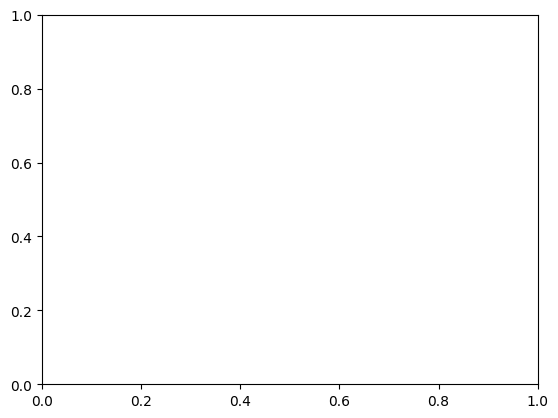

In [19]:
from data_preparation import generate_histogram
generate_histogram(test_predictions.cpu(), hr_train)

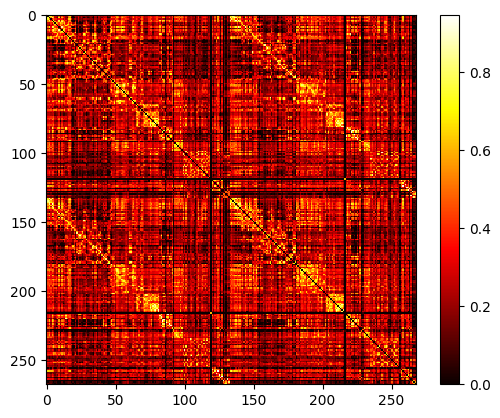

In [33]:
from data_preparation import generate_heatmap
generate_heatmap(test_predictions[0].cpu())

In [99]:
from data_preparation import generate_submission_file

df = generate_submission_file(test_predictions.cpu(), 'submission_files/x5_upsampling.csv')

# Cross Validation

In [11]:
from evaluation_fn import evaluate_predictions

def validation(up_changer, testloader, val_adj_hr):
    print('begin validation')
    up_changer.eval()

    val_predictions = []
    for X_lr, Y_lr, adj_lr in tqdm(testloader):
        pred = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))[-1].detach()
        val_predictions.append(pred)
    val_predictions = torch.cat(val_predictions)

    return evaluate_predictions(val_predictions, val_adj_hr)

In [12]:
def cross_validate(epochs, batch_size, n_fold, X_lr, Y_lr, adj_lr, X_hr, Y_hr, adj_hr, num_steps, f=32):
    kf = KFold(n_fold, shuffle=True, random_state=99)
    runs_results = []
    for train_idx, val_idx in kf.split(X_lr):
        train_X_lr, val_X_lr = X_lr[train_idx], X_lr[val_idx]
        train_Y_lr, val_Y_lr = Y_lr[train_idx], Y_lr[val_idx]
        train_adj_lr, val_adj_lr = adj_lr[train_idx], adj_lr[val_idx]
        train_X_hr = X_hr[train_idx]
        train_Y_hr = Y_hr[train_idx]
        train_adj_hr, val_adj_hr = adj_hr[train_idx], adj_hr[val_idx]

        trainloader = DataLoader(list(zip(train_X_lr, train_Y_lr, train_adj_lr, train_X_hr, train_Y_hr, train_adj_hr)), shuffle=True, batch_size=batch_size)

        dim_steps = generate_steps(num_steps=10)

        up_changer = AdjacencyDimChanger(dim_steps, f=f).to(DEVICE)
        down_changer = AdjacencyDimChanger(dim_steps[::-1], f=f).to(DEVICE)

        up_optimizer = torch.optim.AdamW(up_changer.parameters(), lr=0.001, betas=(0.5, 0.999))
        down_optimizer = torch.optim.AdamW(down_changer.parameters(), lr=0.001, betas=(0.5, 0.999))    
        
        up_changer, down_changer, _ = train(epochs, up_changer, down_changer, trainloader, up_optimizer, down_optimizer)

        testloader = DataLoader(list(zip(val_X_lr, val_Y_lr, val_adj_lr)), shuffle=True, batch_size=batch_size)
        val_metrics = validation(up_changer, testloader, val_adj_hr)
        runs_results.append(val_metrics)

    return runs_results

In [15]:
cross_validate(5, 32, 3, lr_X_dim1, lr_X_dim3, lr_train, hr_X_dim1, hr_X_dim3, hr_train, num_steps=10)

100%|██████████| 4/4 [00:05<00:00,  1.46s/it]


epoch 0: down loss = 0.16564956307411194, up loss = 0.17200086265802383
Down end adj mae 0.28989551216363907
Up end adj mae 0.30541523545980453


100%|██████████| 4/4 [00:04<00:00,  1.23s/it]


epoch 1: down loss = 0.1615280844271183, up loss = 0.16848218068480492
Down end adj mae 0.2799903079867363
Up end adj mae 0.29920385777950287


100%|██████████| 4/4 [00:04<00:00,  1.22s/it]


epoch 2: down loss = 0.1559770405292511, up loss = 0.16499020531773567
Down end adj mae 0.27102500945329666
Up end adj mae 0.29710303246974945


100%|██████████| 4/4 [00:04<00:00,  1.21s/it]


epoch 3: down loss = 0.15054432675242424, up loss = 0.16159073635935783
Down end adj mae 0.2658237814903259
Up end adj mae 0.28980008512735367


100%|██████████| 4/4 [00:04<00:00,  1.21s/it]


epoch 4: down loss = 0.14580555632710457, up loss = 0.15819920599460602
Down end adj mae 0.24981610849499702
Up end adj mae 0.2819031700491905
begin validation


100%|██████████| 2/2 [00:00<00:00,  4.53it/s]
